# PAM for Digital Source Signals
Markus Gardill, 2019

In [1]:
import numpy as np
from sympy.combinatorics.graycode import GrayCode
import matplotlib.pyplot as plt

from IPython.display import Markdown

In [2]:
figsize_1 = (20/2.54, 10/2.54)

## Simulation Parameters

Sample Rate and Sample Period used for simulation

In [3]:
f_s = 1
T_s = 1/f_s

Number of Bits to transmit

In [4]:
N_bits  = 20

## Modulation Parameters

Number of bits per Symbol

In [5]:
M = 2

Symbol duration

In [6]:
T_symb = 10*T_s

Number of symbols necessary

In [7]:
K = 2**M
display(K)

4

## Source Signal

In [8]:
b = np.random.randint(0,2,N_bits)
display(b)

array([1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1])

## Symbol Mapping

Define a function which maps 1D array `b` using `M` bits per symbol to a Gray code.
The Gray code for a given number `M` of bits can be obtained from the class `GrayCode` of `sympy.combinatorics.graycode`.
To map the array `b` of bits to the gray code symbols, first the array reshaped into a $len(b)/M \times M$ matrix, and then for each row (resulting symbol) of the matrix, the corresponding unsigned integer number representation is calculated by multiplying $2^l$ to column $l$ and then summing over the columns. Those integer numbers can then be used to index into the Gray code list.

In [9]:
def gray_code_mapper(b, M):
    b = np.asarray(b)
    # gray code list
    code_mapper = GrayCode(M)
    gray_code_list = np.array(list(code_mapper.generate_gray()))
    # compute the index into gray code list
    gray_index = np.sum(b.reshape(-1,M)*2**np.tile(np.arange(0,M),(b.reshape(-1,M).shape[0],1)), axis=1)
    # compute gray code represenation
    if not gray_index.size == 0:
        output_gray = gray_code_list[gray_index]
    else:
        output_gray = []
    return output_gray, gray_code_list

Display the Gray code mapping

In [10]:
_, gray_code = gray_code_mapper([], M)
display(["{0:02b}".format(val) for val in np.arange(2**M)])
display(gray_code.tolist())

['00', '01', '10', '11']

['00', '01', '11', '10']

Define the symbol mapper. For $M$-PAM equispaced symbols centered around zero are used.

In [11]:
def symbol_mapper_mpam(b, M):
    # symbols table
    table_symbols = np.arange(0, 2**M) - 2**(M-1) + 0.5
    # compute index into symbol table
    idx_symbols_table = [int(b,2) for b in b]
    return table_symbols[idx_symbols_table], table_symbols

Plot the used symbol mapping table

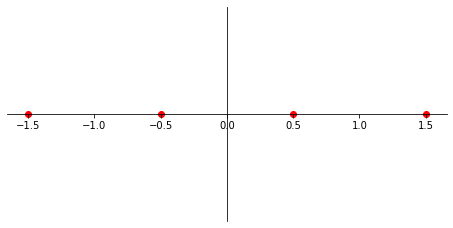

In [24]:
_, table_symbols = symbol_mapper_mpam([], M)
fig = plt.figure()
fig.set_size_inches(figsize_1)
ax1 = plt.subplot(1,1,1)
ax1.spines['bottom'].set_position('zero')
ax1.spines['left'].set_position('zero')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
plt.ylim([-1.5,1.5])
plt.yticks([],[])
plt.scatter(table_symbols,np.zeros(table_symbols.shape), color="red")
#plt.grid()
plt.savefig("pam_digital_constellation", dpi=300)
plt.show()

In [110]:
b_coded,_ = gray_code_mapper(b, M)
symbols, _ = symbol_mapper_mpam(b_coded, M)
t_symbols = np.arange(0, symbols.shape[0]) * T_symb
display(b_coded.tolist())
display(symbols.tolist())
display(t_symbols)

['10', '00', '01', '11', '10', '11', '10', '00', '10', '11']

[0.5, -1.5, -0.5, 1.5, 0.5, 1.5, 0.5, -1.5, 0.5, 1.5]

array([ 0., 10., 20., 30., 40., 50., 60., 70., 80., 90.])

## Ideal PAM

The upsampling factor is given as ratio of symbol duration and sample duration

In [111]:
N_up = round(T_symb / T_s)
display("Upsampling factor is {}".format(N_up))

'Upsampling factor is 10'

Upsample the signal using some array manipulation

In [112]:
sig_pam_ideal = np.concatenate([np.atleast_2d(symbols), np.zeros((N_up-1, symbols.shape[0]))]).flatten('F')
t_ideal = np.arange(0, len(sig_pam_ideal) * T_s, T_s)

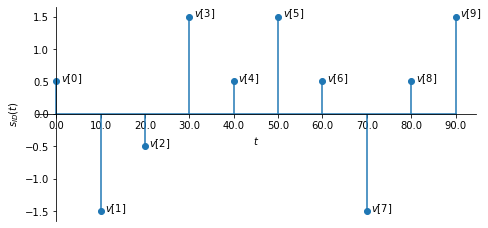

In [156]:
fig = plt.figure()
fig.set_size_inches(figsize_1)
ax = plt.subplot(1,1,1)
markerline, stemlines, baseline = ax.stem(t_symbols, symbols, use_line_collection=True)
plt.setp(baseline, "color", markerline.get_color())
for k in range(symbols.shape[0]):
    plt.text(t_symbols[k]+0.1*T_symb, symbols[k], f"$v[{k}]$")
plt.xlabel('$t$')
plt.ylabel('$s_{ID}(t)$')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(t_symbols, t_symbols)
plt.savefig('pam_digital_ideal', dpi = 300)
plt.show()

## PAM With Impulse Shaping

In [117]:
t_g_t = np.arange(-2*T_symb, 2*T_symb, T_s)
t_g_t

array([-20., -19., -18., -17., -16., -15., -14., -13., -12., -11., -10.,
        -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
         2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,
        13.,  14.,  15.,  16.,  17.,  18.,  19.])

In [118]:
g_t = np.sinc(t_g_t/T_symb)

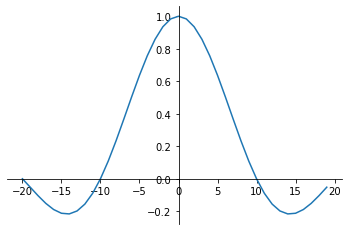

In [174]:
fig = plt.figure()
ax = plt.subplot(1,1,1)
plt.plot(t_g_t, g_t)
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig("pam_digital_g_t", dpi=300)
plt.show()

Create individual shifted copies of $g_T(t)$; column $k$ of `sig_pam_g_t_copies` thus represents
$$
v[k] g_T(t-kT_S)
$$

In [120]:
t_g_t_copies = np.arange(np.min(t_g_t), len(symbols)*N_up+np.max(t_g_t), T_s)
sig_pam_g_t_copies = np.zeros((t_g_t_copies.shape[0], symbols.shape[0]))
idx_g_t_center = np.argwhere(t_g_t == 0)[0][0]
for k in range(symbols.shape[0]):
    idx_current_symbol = np.argwhere(t_g_t_copies == k*T_symb)[0][0]
    idx_start = idx_current_symbol - idx_g_t_center
    idx_end = idx_start + len(g_t)
    sig_pam_g_t_copies[idx_start:idx_end, k] = g_t * symbols[k]

In [121]:
idx_end

130

In [122]:
sig_pam_filtered = np.convolve(sig_pam_ideal, g_t)[round(len(g_t)/2):-round(len(g_t)/2)+1]

Plot the signals

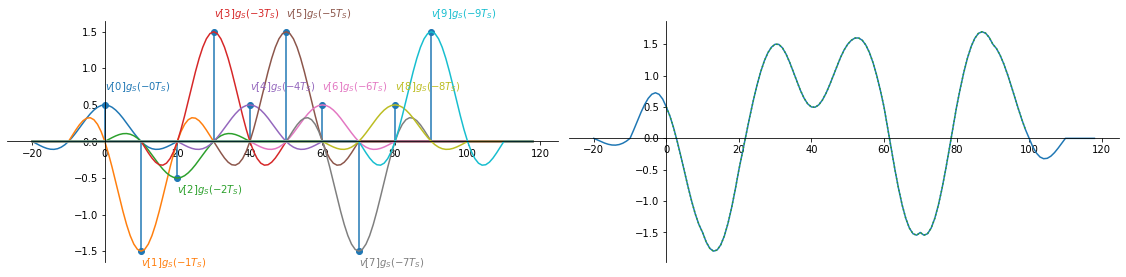

In [170]:
fig = plt.figure()
fig.set_size_inches(np.array(figsize_1) * np.array([2,1]) )
ax = plt.subplot(1,2,1)
markerline, stemlines, baseline = ax.stem(t_symbols, symbols, use_line_collection=True)
plt.setp(baseline, "color", markerline.get_color())
plt.plot(t_g_t_copies,sig_pam_g_t_copies)
for k in range(symbols.shape[0]):
    plt.text(t_symbols[k], symbols[k]+0.2*np.sign(symbols[k]), f"$v[{k}]g_S(-{k}T_S)$", color=f"C{k}")
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = plt.subplot(1,2,2)
plt.plot(t_g_t_copies,np.sum(sig_pam_g_t_copies, axis=1), '-')
plt.plot(t_ideal, sig_pam_filtered, 'C2:')
#plt.plot(t_ideal, sig_pam_ideal)
#plt.grid()
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig("pam_digital_real", dpi=300)
plt.show()

In [146]:
np.array(figsize_1) * np.array([2,1]) 

array([15.7480315 ,  3.93700787])

In [129]:
symbols

array([ 0.5, -1.5, -0.5,  1.5,  0.5,  1.5,  0.5, -1.5,  0.5,  1.5])

## Split into Tx and Rx

## AWGN Channel

In [124]:
r_awgn = sig_pam_filtered + 0.1*np.random.randn(*sig_pam_filtered.shape)

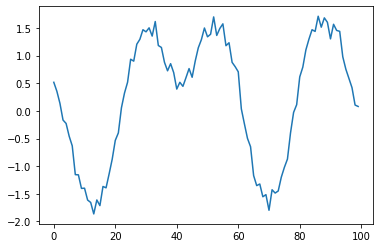

In [125]:
fig = plt.figure()
plt.plot(r_awgn)
plt.show()